In [1]:
import os
import random
import math
import kornia
import numpy as np
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# random.seed(0)
# np.random.seed(0)
# torch.manual_seed(0);

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(109, 134)
val_labeled_scene_index = np.arange(106, 109)
test_labeled_scene_index = np.arange(106, 109)

from helper import compute_ats_bounding_boxes, compute_ts_road_map
from utils.angles import within_angles

In [2]:
VERT_BLOCK_SIZE = 10
HORIZ_BLOCK_SIZE = 10
BLOCK_AREA = VERT_BLOCK_SIZE * HORIZ_BLOCK_SIZE

In [3]:
def blur(img):
    img = img.unsqueeze(0)
    blurred = kornia.filters.gaussian_blur2d(img, kernel_size=(5, 5), sigma=(9.5, 9.5))
    return blurred.squeeze(0)

In [4]:
def collate_fn(batch):
    left_images = []
    target = []
    road_maps = []
    bbox_maps = []
    bbox_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2]).float()
        road_maps.append(road_image)
        
        # Collect front-left image.  
        # Try cutting off the top 130 pixels (that can lead to overfitting)
        image = torch.Tensor(x[0][1])[:, 130:, :]
        left_images.append(image)
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bbox_map = torch.zeros((800, 800))
        counts = np.zeros(28)
        count = 0
        
        # Create the bounding box map. 
        for i, corners in enumerate(bb_tens):
            
            # Grab the current bounding box. 
            current_bbs.append(corners)
            
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # xs is horizontal, ys is vertical through. 
            # But we're doing things row, column way. 
            
            # Only get the bounding boxes that are close-by. On the same road. 
            # We want to see if the model can fucking predict cars that are close by. 
            
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            if (within_angles(xs, ys, angle1=333, angle2=360) or \
                within_angles(xs, ys, angle1=0, angle2=30)) and \
                center_y > 290 and center_y < 470 and center_x < 650:
            
                # Grab the top-left coordinates. 
                r, c = int(torch.min(ys).item()), int(torch.min(xs).item())
                r_len, c_len = int(torch.max(ys).item()) - r, int(torch.max(xs).item()) - c

                # Fill in the bbox. 
                bbox_map[r:r+r_len, c:c+c_len] = 1.0

                count += 1
            
        # Convert the bounding box map into classes (5px by 5px bins)
        bbox_grid = []
        for x_ in range(0, 800, VERT_BLOCK_SIZE):
            for y in range(0, 800, HORIZ_BLOCK_SIZE):
                block = bbox_map[x_:x_+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as bbox car
                if score > 0.5 * (BLOCK_AREA):
                    bbox_grid.append(1.0)
                else:
                    bbox_grid.append(0.0)
                    
        bbox_bins.append(torch.Tensor(bbox_grid))
              
        counts[count] = 1

        # Label Smoothing #
#         if count > 15 and count < 88:
#             counts[count+1] = 0.2
#             counts[count-1] = 0.2
            
        target_counts.append(torch.Tensor(counts))
        
        bbox_maps.append(bbox_map)

        bbs.append(current_bbs)
                
    boom = torch.stack(left_images), torch.stack(bbox_bins), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(bbox_maps) 
    return boom

In [5]:
val_transform = transforms.ToTensor()

train_transform = transforms.Compose([
    transforms.ColorJitter(brightness = 0.5, contrast = 0.5, saturation = 0.4, hue = (-0.5, 0.5)),
    transforms.RandomApply([
        transforms.Grayscale(3),
#         transforms.RandomAffine(1),
    ]),
    transforms.ToTensor(),
    transforms.RandomApply([
        transforms.Lambda(lambda img: blur(img)),
    ])
])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

#### Testing

In [66]:
train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=16, shuffle=True, collate_fn=collate_fn)

In [67]:
# Compute threat scores
def reconstruct_from_bins(bins, threshold):
    print(bins.shape)
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, VERT_BLOCK_SIZE):
        for y in range(0, 800, HORIZ_BLOCK_SIZE):
            road_map[x:x+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE] = bins[idx]
            idx += 1
    return road_map > threshold

In [68]:
sample, bbox_bins, road_maps, bbs, counts, bbox_maps  = iter(train_loader).next()

In [69]:
idx = -1

In [108]:
idx += 1

tensor(4)


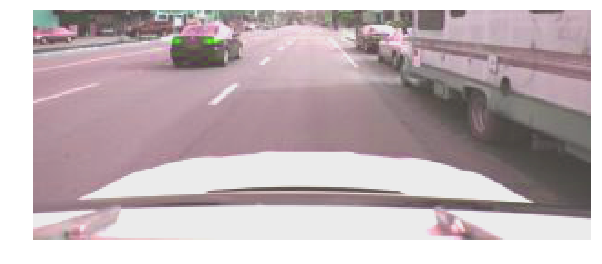

In [109]:
print(torch.argmax(counts[idx]))
matplotlib.rcParams['figure.figsize'] = [10,10]
plt.imshow(sample[idx].numpy().transpose(1, 2, 0))
plt.axis('off');

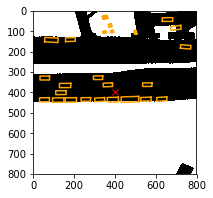

In [110]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]
fig, ax = plt.subplots()
ax.imshow(road_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bbs[idx]:
    draw_box(ax, bb, 'orange')

torch.Size([6400])


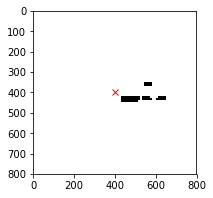

In [111]:
threshold = 0.5
road_map = reconstruct_from_bins(bbox_bins[idx], threshold)
fig, ax = plt.subplots()
ax.imshow(road_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")

### Model

In [6]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet18()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 100
        self.dropout = nn.Dropout(p = 0.2)
        self.bn = nn.BatchNorm1d(self.concat_dim)
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(512, 100)),
            ('relu', nn.ReLU()),
        ]))
        
        self.vehicle_map = nn.Sequential(OrderedDict([
            ('linear1_vehicle', nn.Linear(self.concat_dim, 6400)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, 28))
        ]))
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        channels = x.shape[1]
        height = x.shape[2]
        width = x.shape[3]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        x = self.bn(x)
        x = self.dropout(x)
    
        return self.vehicle_map(x), self.counts(x)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleModel()
model.load_state_dict(torch.load('/scratch/vr1059/front_image_resnet18_val_new_gauss_5_top_130_super_near.pt'))
model = model.to(device)
map_criterion = nn.BCEWithLogitsLoss()
count_criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
best_val_loss = 100

In [8]:
def train():
    model.train()
    labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=train_transform,
                                  extra_info=True
                                 )
    train_loader = torch.utils.data.DataLoader(labeled_trainset, batch_size=15, num_workers=15, shuffle=True, collate_fn=collate_fn)
    
    train_losses = []
    map_losses = []
    count_losses = []
    f = open(log_file_path, "a+")
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(train_loader):
        optimizer.zero_grad()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)
        
        y_vehicle, y_count = model(sample)
        
        map_loss = map_criterion(y_vehicle, bbox_bins.float())
        count_loss = count_criterion(y_count, target_count.float())
        loss = 0.99 * map_loss + 0.01 * count_loss
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        map_losses.append(map_loss.item())
        count_losses.append(count_loss.item())
        if i % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(sample), len(train_loader.dataset),
                50. * i / len(train_loader), loss.item()))
            
    print("\nAverage Train Epoch Loss: ", np.mean(train_losses))
    print("Average Train Map Loss: ", np.mean(map_losses))
    print("Average Train Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Train Epoch Loss: {}".format(np.mean(train_losses)))
    f.write("Average Train Map Loss: {}".format(np.mean(map_losses)))
    f.write("Average Train Count Epoch Loss: {}".format(np.mean(count_losses)))
    
    f.close()
    
            
def val():
    
    val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=15, num_workers=5, shuffle=True, collate_fn=collate_fn)
    model.eval()
    val_losses = []
    map_losses = []
    count_losses = []
    
    f = open(log_file_path, "a+")
    
    for i, (sample, bbox_bins, road_maps, bbs, target_count, _) in enumerate(val_loader):

        model.eval()

        sample = sample.to(device)
        bbox_bins = bbox_bins.to(device)
        target_count = target_count.to(device)

        with torch.no_grad():
            y_vehicle, y_count = model(sample)
        
            map_loss = map_criterion(y_vehicle, bbox_bins.float())
            count_loss = count_criterion(y_count, target_count.float())
            loss = 0.99 * map_loss + 0.01 * count_loss
            
            val_losses.append(loss.item())
            map_losses.append(map_loss.item())
            count_losses.append(count_loss.item())
            
    print("\tAverage Validation Epoch Loss: ", np.mean(val_losses))
    print("\tAverage Validation Map Epoch Loss: ", np.mean(map_losses))
    print("\tAverage Validation Count Epoch Loss: ", np.mean(count_losses))
    
    f.write("\nAverage Validation Epoch Loss: {}".format(np.mean(val_losses)))
    f.write("\tAverage Validation Map Epoch Loss: {}".format(np.mean(map_losses)))
    f.write("\tAverage Validation Count Epoch Loss: {}".format(np.mean(count_losses)))

    global best_val_loss
    if np.mean(map_losses) < best_val_loss:
        best_val_loss = np.mean(map_losses)
        f.write("\n best_val_loss so far: {}".format(best_val_loss))
        torch.save(model.state_dict(), '/scratch/vr1059/front_image_resnet18_val_new_gauss_5_top_130_super_near.pt')
        
    f.close()

In [9]:
log_file_path = "front_image_resnet_18_val_new_gauss_5_top_130_super_near.log"

In [ ]:
epochs = 65
for epoch in range(epochs):
    train()
    val()

Train Epoch: 0 [0/3150 (0%)]	Loss: 0.007451
Train Epoch: 0 [750/3150 (12%)]	Loss: 0.005177
Train Epoch: 0 [1500/3150 (24%)]	Loss: 0.005153
Train Epoch: 0 [2250/3150 (36%)]	Loss: 0.006868
Train Epoch: 0 [3000/3150 (48%)]	Loss: 0.007633

Average Train Epoch Loss:  0.007205581968827616
Average Train Map Loss:  0.006619557667346228
Average Train Count Epoch Loss:  0.06522198236059575
	Average Validation Epoch Loss:  0.007484629383095755
	Average Validation Map Epoch Loss:  0.006851969447989876
	Average Validation Count Epoch Loss:  0.0701179586064357
Train Epoch: 1 [0/3150 (0%)]	Loss: 0.006245
Train Epoch: 1 [750/3150 (12%)]	Loss: 0.004221
Train Epoch: 1 [1500/3150 (24%)]	Loss: 0.005380
Train Epoch: 1 [2250/3150 (36%)]	Loss: 0.006901
Train Epoch: 1 [3000/3150 (48%)]	Loss: 0.005575

Average Train Epoch Loss:  0.006785977228234211
Average Train Map Loss:  0.006209088215560076
Average Train Count Epoch Loss:  0.06389798296704179
	Average Validation Epoch Loss:  0.00740662281616376
	Average Va

Train Epoch: 15 [0/3150 (0%)]	Loss: 0.003662
Train Epoch: 15 [750/3150 (12%)]	Loss: 0.003599
Train Epoch: 15 [1500/3150 (24%)]	Loss: 0.003890
Train Epoch: 15 [2250/3150 (36%)]	Loss: 0.003681
Train Epoch: 15 [3000/3150 (48%)]	Loss: 0.006137

Average Train Epoch Loss:  0.0044409013275677955
Average Train Map Loss:  0.004007323007542817
Average Train Count Epoch Loss:  0.0473651530309802
	Average Validation Epoch Loss:  0.006252584047615528
	Average Validation Map Epoch Loss:  0.0056034133393460745
	Average Validation Count Epoch Loss:  0.0705204841036063
Train Epoch: 16 [0/3150 (0%)]	Loss: 0.003510
Train Epoch: 16 [750/3150 (12%)]	Loss: 0.003508
Train Epoch: 16 [1500/3150 (24%)]	Loss: 0.004030
Train Epoch: 16 [2250/3150 (36%)]	Loss: 0.002991
Train Epoch: 16 [3000/3150 (48%)]	Loss: 0.004337

Average Train Epoch Loss:  0.004227894647712154
Average Train Map Loss:  0.0038154028417054743
Average Train Count Epoch Loss:  0.04506458132749512
	Average Validation Epoch Loss:  0.00645696956556863

In [60]:
# 0.01164 so far. 

# 0.01079